### Investigation of the effect of contrast on the performance of Deep Learning Contouring
In this study, a cohort of 141 patients was used to invetigate whether contrast in CT scans can affect the performance of Deep Learning Contouring model available on MIRADA application. All the 141 patients have with-contrast, without contrast CTs, and all of them have deep learning contours base on  with-contrast and without contrast CTs along with manual contours based on with contrast CTs.


In this notebook, I will implement Surface Dice, residual scatter plot, violin plot, and heatmaps along with different statistical tests to compare the surface area features made based on manual contour and deep learning contours.

In [1]:
# Import packages

# General packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.linear_model import LinearRegression
from scipy.stats import shapiro, levene, wilcoxon, f_oneway
from scipy.stats import kruskal, bartlett, ttest_ind, ttest_rel

# Image analysis packages
import SimpleITK as sitk
import seg_metrics.seg_metrics as sg
from surface_distance import metrics
from surface_distance.metrics import *

c:\Users\BahrdoH\AppData\Local\anaconda3\envs\radiomics_env\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


### Making the datasets.

In [2]:
def normalizing_feature(x):
    normalized_x = (x - np.mean(x)) / np.std(x)
    return normalized_x

In [3]:
mc_bsl_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Rf_bsl_mc_checker_total.xlsx'
dlc_bsl_with_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Rf_bsl_dlc_total.xlsx'
dlc_bsl_without_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Rf_bsl_dlc_withoutC_total.xlsx'
mc_wk3_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Rf_wk3_mc_total.xlsx'
dlc_wk3_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Rf_wk3_dlc_total.xlsx'

# Make dataset with manual contouring and deep learning and without contrast.
mc_bsl_df = pd.read_excel(mc_bsl_path).drop(columns=['Unnamed: 0'])
dlc_bsl_without_df = pd.read_excel(dlc_bsl_without_path).drop(columns=['Unnamed: 0'])
mc_wk3_df = pd.read_excel(mc_wk3_path).drop(columns=['Unnamed: 0'])
dlc_wk3_df = pd.read_excel(dlc_wk3_path).drop(columns=['Unnamed: 0'])

# BSL
dlc_bsl_with_df = pd.read_excel(dlc_bsl_with_path)
dlc_bsl_with_df['Unnamed: 0'] = dlc_bsl_with_df['Unnamed: 0'].fillna(method='ffill')
dlc_bsl_with_df.rename(columns= {'Unnamed: 0':'ID', 'Unnamed: 1': 'OAR'}, inplace=True)
dlc_bsl_with_df.ID = dlc_bsl_with_df.ID.astype(int)
dlc_bsl_with_df = dlc_bsl_with_df[dlc_bsl_with_df.ID.isin(list(mc_bsl_df.ID.unique()))]
dlc_bsl_with_df.ID.nunique()

mc_bsl_df = mc_bsl_df[~(mc_bsl_df.ID.astype(str).str.contains('1737477'))].reset_index().drop(columns=['index'])
dlc_bsl_without_df = dlc_bsl_without_df[~(dlc_bsl_without_df.ID.astype(str).str.contains('1737477'))].reset_index().drop(columns=['index'])

# WK3
dlc_wk3_df = dlc_wk3_df[dlc_wk3_df.ID.isin(list(mc_wk3_df.ID.unique()))]
mc_wk3_df = mc_wk3_df[mc_wk3_df.ID.isin(list(dlc_wk3_df.ID.unique()))]

mc_total_df = mc_bsl_df[mc_bsl_df.OAR == 'total']
dlc_with_total_df = dlc_bsl_with_df[dlc_bsl_with_df.OAR == 'total']
dlc_without_total_df = dlc_bsl_without_df[dlc_bsl_without_df.OAR == 'total']
mc_wk3_total_df = mc_wk3_df[mc_wk3_df.OAR == 'total']
dlc_wk3_total_df = dlc_wk3_df[dlc_wk3_df.OAR == 'total']


dlc_with_total_df = dlc_with_total_df.set_index('ID').sort_index()
mc_total_df = mc_total_df.set_index('ID').sort_index()
dlc_without_total_df = dlc_without_total_df.set_index('ID').sort_index()
dlc_wk3_total_df = dlc_wk3_total_df.set_index('ID').sort_index()
mc_wk3_total_df = mc_wk3_total_df.set_index('ID').sort_index()

mc = mc_total_df[['original_shape_VoxelVolume', 'original_shape_SurfaceArea']]
dlc_with = dlc_with_total_df[['original_shape_VoxelVolume', 'original_shape_SurfaceArea']]
dlc_without = dlc_without_total_df[['original_shape_VoxelVolume', 'original_shape_SurfaceArea']]
mc_wk3 = mc_wk3_total_df[['original_shape_VoxelVolume', 'original_shape_SurfaceArea']]
dlc_wk3= dlc_wk3_total_df[['original_shape_VoxelVolume', 'original_shape_SurfaceArea']]

norm_mc_vol = normalizing_feature(mc.original_shape_VoxelVolume)
norm_with_vol = normalizing_feature(dlc_with.original_shape_VoxelVolume)
norm_mc_surf = normalizing_feature(mc.original_shape_SurfaceArea)
norm_with_surf = normalizing_feature(dlc_with.original_shape_SurfaceArea)
norm_without_vol = normalizing_feature(dlc_without.original_shape_VoxelVolume)
norm_without_surf = normalizing_feature(dlc_without.original_shape_SurfaceArea)
norm_mc_wk3_vol = normalizing_feature(mc_wk3.original_shape_VoxelVolume)
norm_dlc_wk3_vol = normalizing_feature(dlc_wk3.original_shape_VoxelVolume)
norm_mc_wk3_surf = normalizing_feature(mc_wk3.original_shape_SurfaceArea)
norm_dlc_wk3_surf = normalizing_feature(dlc_wk3.original_shape_SurfaceArea)

In [5]:
def making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict, line=False, line_info = [], logistic=True):
    plt.figure(figsize=(10,10))

    for counter, x_element in enumerate(x_element_list): 
        plt.scatter(x=x_element, y=y_element_list[counter], color=color_list[counter], alpha=alpha_list[counter], marker='o', label=label_list[counter])

        if logistic:
            X = x_element.values.reshape(-1, 1)
            y = y_element_list[counter].values.reshape(-1, 1)

            # Create and fit a linear regression model
            model = LinearRegression()
            model.fit(X, y)

            plt.plot(X, model.predict(X), color='salmon',  linestyle=':', linewidth=2, label='Fitted Line')
    
    if line:
        plt.plot(line_info[0], line_info[1], label=line_info[2])



    # Add labels to the plot
    plt.xlabel(figure_dict['x'], fontsize=16)
    plt.ylabel(figure_dict['y'], fontsize=16)

    # Add a title to the plot
    plt.title(figure_dict['title'], fontsize=18)

    # Add support lines in the x and y axes
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Add a legend to the plot
    plt.legend()

    # Save this plot
    plt.savefig('surface_vol.png')
    # Display the plot
    plt.show()

def making_histogram(element_list, color_list, label_list, alpha_list, figure_dict):
    # Create a histogram
    plt.figure(figsize=(10, 5))
    n, bins, patches = plt.hist(element_list[0], bins=30, color=color_list[0], density=True, edgecolor='black', alpha=0.7, label=label_list[0])

    # Add a line plot (probability density function)
    sns.kdeplot(element_list[0], color='darkgreen', linestyle='dashed')

    plt.axvline(x = np.mean(element_list[0]), color = "darkgreen", linestyle='--', label=f'Mean {label_list[0]}')

    y_place = (np.max(n) * 3) / 4.
    # Annotate the mean value with text
    plt.annotate(f'Mean: {np.mean(element_list[0]):.2f}',
                 xy=(np.mean(element_list[0]), y_place),
                 xytext=(np.mean(element_list[0]) - np.mean(element_list[0]) * 0.15, y_place),
                 arrowprops=dict(arrowstyle='->', edgecolor='black', facecolor='white'),
                 color='darkgreen',
                 fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white'))




    # Add labels to the plot
    plt.xlabel(figure_dict['x'], fontsize=16)
    plt.ylabel(figure_dict['y'], fontsize=16)

    # Add a title to the plot
    plt.title(figure_dict['title'], fontsize=18)

    # Add support lines in the x and y axes
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Add a legend to the plot
    plt.legend()

    # Save this plot
    plt.savefig('Surface Dice.png')

    # Display the plot
    plt.show()

def making_violin_plot(category_df):

    # Create a violin plot using Seaborn
    sns.set(style="whitegrid")
    sns.catplot(kind='violin', data=category_df, height=8, aspect=1.5, palette="Set2")

    # Customize labels and title if needed
    plt.xlabel('Categories', fontsize=16)
    plt.ylabel('Surface Area Value', fontsize=16)
    plt.title('Surface Area value distribution', fontsize=18)
    plt.tight_layout()

    plt.savefig('aaa.png')
    # Show the plot
    plt.show()
    
def calculating_surface_dice(mc_nifti_path, dlc_nifti_path, labels, tolerance):
    surface_features_dict = {}
    for r, d, f in os.walk(mc_nifti_path):
        subfolders = [os.path.join(r, folder) for folder in d]

        for subf in subfolders:

            try:

                directions = os.listdir(subf)
                    
                for direction in directions:

                    if '.nii' in direction:
                    # Makr path to patient DLC NIFTI file
                        pat_ml_path = os.path.join(subf, direction)
                        

                        # Extract the name of the OAR
                        assistant_list = pat_ml_path.split('\\')
                        oar_name =assistant_list[-1][:-4]
                        
                        # Extract the patient ID
                        subf_list = subf.split('\\')
                        patient_id = subf_list[1]

                        print(f'Patient {patient_id} has started')

                        target_nifti_path = os.path.join(dlc_nifti_path, patient_id)

                        for r, d, f in os.walk(target_nifti_path):
                            subfolders1 = [os.path.join(r, folder) for folder in d]
                            #print(subfolders1)
                            if len(subfolders1) !=0:
                                for subf1 in subfolders1:
                                    assistant_path = os.listdir(subf1)
                                    

                                    for name in assistant_path:
                                        #print(name)
                                        if  '.nii' in name.lower() and oar_name.lower() in name.lower():
                                            
                                            pat_dlc_path = os.path.join(subf1, name)
                                            #print('hiiiiiii', pat_dlc_path)

                            #else:
                            #    if 'total' in oar_name:
                            #        pat_dlc_path = os.path.join(dlc_nifti_path, patient_id, f'{oar_name}.nii')
                                    #print(pat_dlc_path)
                                
                            #    else:
                            #        pat_dlc_path = os.path.join(dlc_nifti_path, patient_id, f'DLC_{oar_name}.nii')
                                    
                                    
                        print(f'{oar_name} match for this patient has been found')

                        csv_file = 'metrix.csv'
                        #print(pat_dlc_path)
                        metrics = sg.write_metrics(labels=labels,  # exclude background
                                        gdth_path=pat_ml_path,
                                        pred_path=pat_dlc_path,
                                        csv_file=csv_file)
                
                        vol_gt = sitk.GetArrayFromImage(sitk.ReadImage(pat_ml_path))
                        mask_gt = vol_gt.astype(dtype=bool)
                        vol_seg = sitk.GetArrayFromImage(sitk.ReadImage(pat_dlc_path))
                        mask_seg = vol_seg.astype(dtype=bool)
                        #print(mask_gt)
                        voxel_spacing = sitk.ReadImage(pat_ml_path).GetSpacing()
                        

                        info_image = compute_surface_distances(mask_gt=mask_gt, mask_pred=mask_seg, spacing_mm=voxel_spacing)  

                        surface_dice = compute_surface_dice_at_tolerance(surface_distances=info_image, tolerance_mm=tolerance)

                        # Add new features to the dictionary
                        surface_features_dict[(patient_id, oar_name)] = [surface_dice]
                        print(f'Patient {patient_id} has finished')

            except Exception as e:
                print(e)
        
    df = pd.DataFrame.from_dict(surface_features_dict).transpose()
    df = df.rename(columns={0:'OAR', 1:'Surface_dice'})
    return df

In [ ]:
mc_nifti_path = '//zkh/appdata/RTDicom/Projectline_HNC_modelling/OPC_data/ART Hooman/Hooman_project_data/MC_Baseline_Contrast_Checker_NIFTI'
dlc_nifti_path = '//zkh/appdata/RTDicom/Projectline_HNC_modelling/OPC_data/ART Hooman/Hooman_project_data/DLC_baseline_NIFTI'
labels = [0, 1]
tolerance = 5

df = calculating_surface_dice(mc_nifti_path, dlc_nifti_path, labels, tolerance)

In [18]:
df.to_excel('mc_with_5.xlsx')

## Comparing Different tolerance

In [37]:
df_2_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Dice_MC_DLC_BSL_with.xlsx'
df_3_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/mc_with_3.xlsx'
df_4_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/mc_with_4.xlsx'
df_5_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/mc_with_5.xlsx'
df_6_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/mc_with_6.xlsx'
df_7_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/mc_with_7.xlsx'

In [38]:
def cleaning_df(df):
    df['Unnamed: 0'] = df['Unnamed: 0'].fillna(method='ffill')
    df.rename(columns= {'OAR':'Surface_dice'}, inplace=True)
    df.rename(columns= {'Unnamed: 0':'ID', 'Unnamed: 1': 'OAR'}, inplace=True)
    df.ID = df.ID.astype(int)
    df = df[df.ID.isin(list(mc_bsl_df.ID.unique()))]
    print(df.ID.nunique())

    df = df[df.OAR == 'total']
    df = df.set_index('ID').sort_index()
    df = df.drop(columns=['OAR'])
    return df

In [39]:
df_2 = pd.read_excel(df_2_path)
df_3 = pd.read_excel(df_3_path)
df_4 = pd.read_excel(df_4_path)
df_5 = pd.read_excel(df_5_path)
df_6 = pd.read_excel(df_6_path)
df_7 = pd.read_excel(df_7_path)

In [40]:
df_3 = cleaning_df(df_3)
df_4 = cleaning_df(df_4)
df_5 = cleaning_df(df_5)
df_6 = cleaning_df(df_6)
df_7 = cleaning_df(df_7)

138
138
138
138
138


In [ ]:
aaa = df_7[df_7.Surface_dice > 0.85]
element_list = [aaa.Surface_dice]
color_list = ['limegreen']
label_list = ['MC_DLC_BSL_CONTRAST+']
alpha_list = [0.7]
figure_dict = {'x': 'Surface Dice', 'y': 'Count', 'title':'Surface Dice Distribution (Tol: 7mm)'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

## MC Vs DLC Contrast+

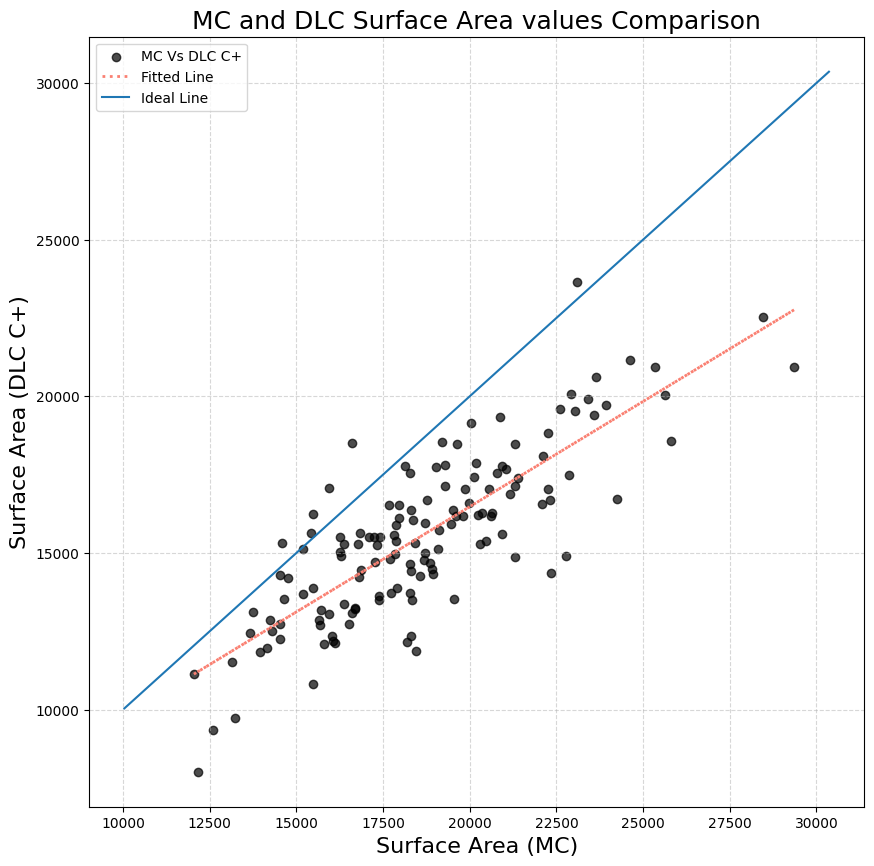

In [7]:
x_element_list = [mc.original_shape_SurfaceArea]
y_element_list = [dlc_with.original_shape_SurfaceArea]

line_info= [[np.min(mc.original_shape_SurfaceArea) -2000, np.max(mc.original_shape_SurfaceArea) + 1000], 
            [np.min(mc.original_shape_SurfaceArea)- 2000, np.max(mc.original_shape_SurfaceArea) + 1000], 'Ideal Line']

color_list = ['black']
label_list = ['MC Vs DLC C+']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Surface Area (MC)', 'y': 'Surface Area (DLC C+)', 'title':'MC and DLC Surface Area values Comparison'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict, True, line_info, True)

### Normalized Version

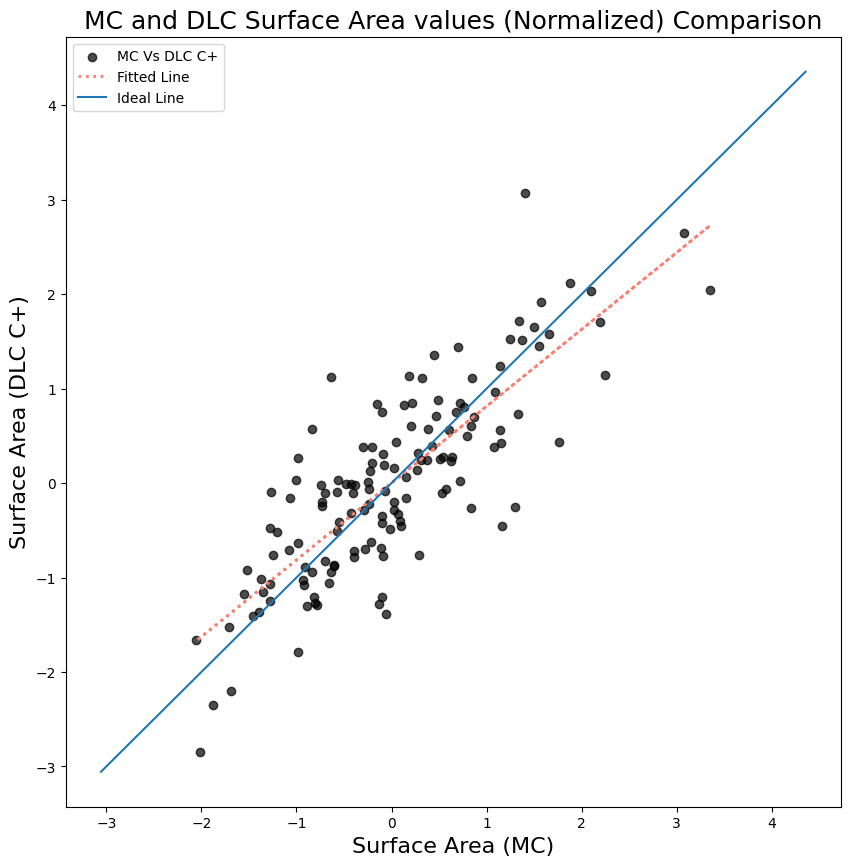

In [12]:
x_element_list = [norm_mc_surf]
y_element_list = [norm_with_surf]

line_info= [[np.min(norm_mc_surf) -1, np.max(norm_mc_surf) + 1], 
            [np.min(norm_mc_surf)- 1, np.max(norm_mc_surf) + 1], 'Ideal Line']

color_list = ['black']
label_list = ['MC Vs DLC C+']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Surface Area (MC)', 'y': 'Surface Area (DLC C+)', 'title':'MC and DLC Surface Area values (Normalized) Comparison'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict, True, line_info, True)

### Violin Plot

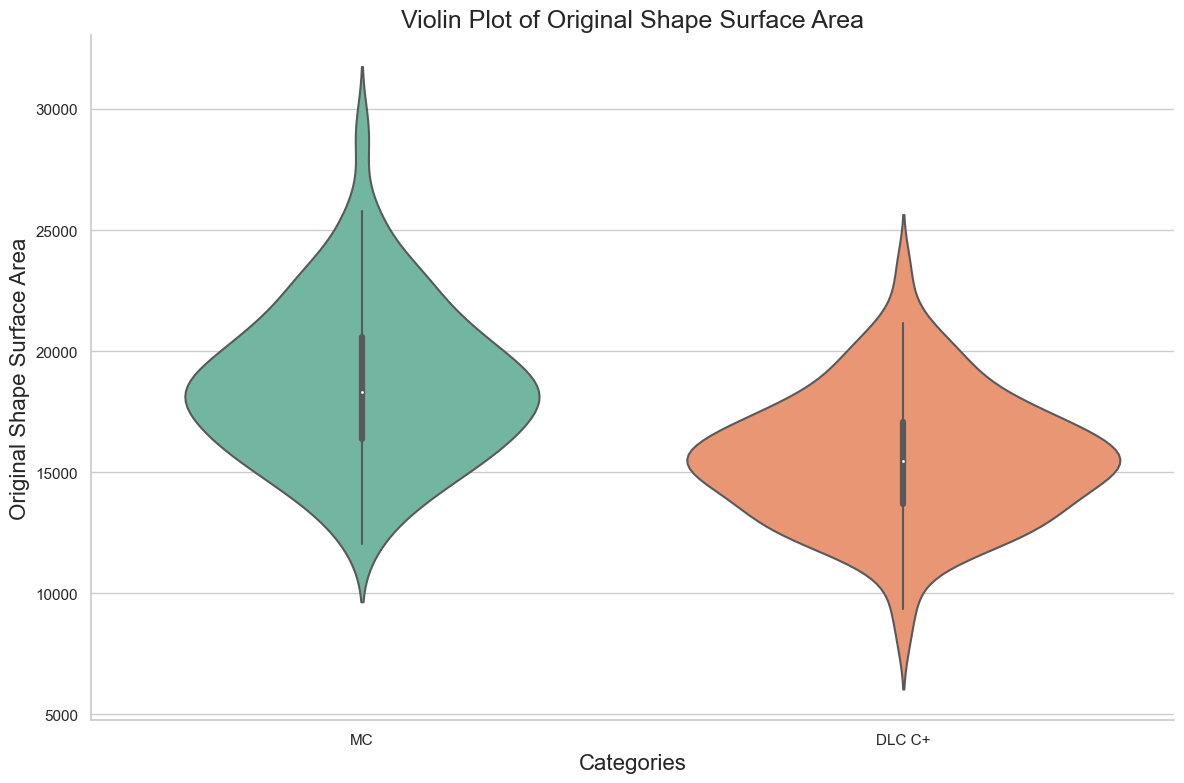

In [19]:
# Extract the relevant columns from each DataFrame
mc_data = mc[['original_shape_SurfaceArea']].reset_index(drop=True)
#without_data = dlc_without[['original_shape_SurfaceArea']].reset_index(drop=True)
with_data = dlc_with[['original_shape_SurfaceArea']].reset_index(drop=True)

# Create the DataFrame
category_df = pd.DataFrame({'MC': mc_data['original_shape_SurfaceArea'],
                            #'Without': without_data['original_shape_SurfaceArea'],
                            'DLC C+': with_data['original_shape_SurfaceArea']})

making_violin_plot(category_df)

### Surface Dice

138


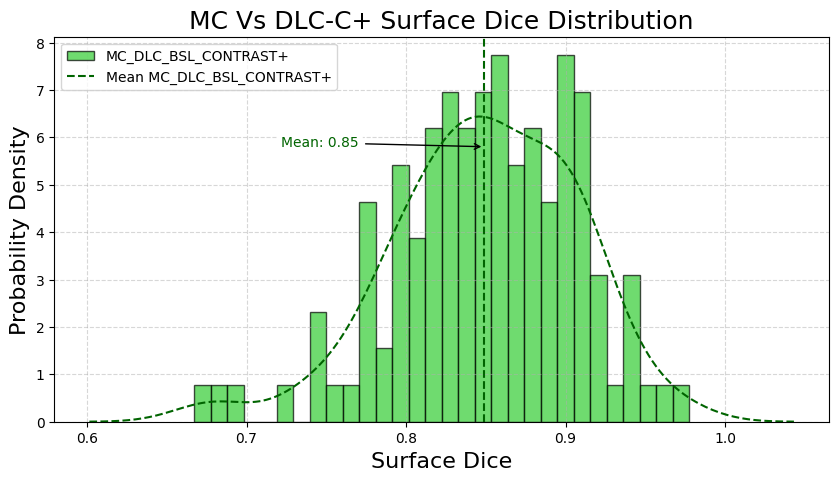

In [13]:
dice_mc_dlc_bsl_with = pd.read_excel('Dice_MC_DLC_BSL_with.xlsx').rename(columns={'Unnamed: 0': 'ID'})
dice_mc_dlc_bsl_with = dice_mc_dlc_bsl_with[dice_mc_dlc_bsl_with.OAR=='total']
print(dice_mc_dlc_bsl_with.ID.nunique())

element_list = dice_mc_dlc_bsl_with[dice_mc_dlc_bsl_with.Surface_dice> 0.5 ]
element_list = [element_list.Surface_dice]

color_list = ['limegreen']
label_list = ['MC_DLC_BSL_CONTRAST+']
alpha_list = [0.7]
figure_dict = {'x': 'Surface Dice', 'y': 'Probability Density', 'title':'MC Vs DLC-C+ Surface Dice Distribution'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

## MC Vs DLC Contrast-

In [40]:
import pandas as pd

# Resetting index of the DataFrames
mc.reset_index(drop=True, inplace=True)
dlc_without.reset_index(drop=True, inplace=True)
dlc_with.reset_index(drop=True, inplace=True)

# Concatenating DataFrames along axis 1
dff = pd.concat([
                 mc.original_shape_SurfaceArea,
                 dlc_without.original_shape_SurfaceArea,
                 dlc_with.original_shape_SurfaceArea], axis=1)

In [58]:
from scipy.stats import shapiro

# Check the normality
stat, p_value = shapiro(mc.original_shape_SurfaceArea)
print(stat, p_value)

stat, p_value = shapiro(dlc_without.original_shape_SurfaceArea)
print(stat, p_value)

stat, p_value = shapiro(dlc_with.original_shape_SurfaceArea)
print(stat, p_value)

0.9814663529396057 0.05451095849275589
0.9902820587158203 0.4426496922969818
0.9928326606750488 0.7065832018852234


In [62]:
from scipy.stats import levene
# Perform Levene's test
statistic, p_value = levene(mc.original_shape_SurfaceArea, dlc_without.original_shape_SurfaceArea)

# Print the results
print("Test Statistic:", statistic)
print("p-value:", p_value)

# Determine the significance
alpha = 0.05  # Set your desired significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in variances.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference")

Test Statistic: 2.828284505822128
p-value: 0.0937401796420965
Fail to reject the null hypothesis: There is no significant difference


In [63]:
from scipy.stats import levene
# Perform Levene's test
statistic, p_value = levene(mc.original_shape_SurfaceArea, dlc_with.original_shape_SurfaceArea)

# Print the results
print("Test Statistic:", statistic)
print("p-value:", p_value)

# Determine the significance
alpha = 0.05  # Set your desired significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in variances.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference")

Test Statistic: 3.8309725097532907
p-value: 0.05131423948478222
Fail to reject the null hypothesis: There is no significant difference


In [64]:
from scipy.stats import levene
# Perform Levene's test
statistic, p_value = levene(dlc_without.original_shape_SurfaceArea, dlc_with.original_shape_SurfaceArea)

# Print the results
print("Test Statistic:", statistic)
print("p-value:", p_value)

# Determine the significance
alpha = 0.05  # Set your desired significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in variances.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference")

Test Statistic: 0.076643154027137
p-value: 0.7821048538864918
Fail to reject the null hypothesis: There is no significant difference


In [8]:
from scipy.stats import bartlett

# Perform Bartlett's test
statistic, p_value = bartlett(mc.original_shape_SurfaceArea, dlc_without.original_shape_SurfaceArea)

# Print the results
print(f"Test Statistic: {statistic}")
print(f"P-value: {p_value}")

# Check the p-value against a significance level (e.g., 0.05)
if p_value < 0.05:
    print("The variances are significantly different.")
else:
    print("There is no significant difference in variances.")

Test Statistic: 3.627088871023017
P-value: 0.05684616856518849
There is no significant difference in variances.


In [9]:
from scipy.stats import bartlett

# Perform Bartlett's test
statistic, p_value = bartlett(mc.original_shape_SurfaceArea, dlc_with.original_shape_SurfaceArea)

# Print the results
print(f"Test Statistic: {statistic}")
print(f"P-value: {p_value}")

# Check the p-value against a significance level (e.g., 0.05)
if p_value < 0.05:
    print("The variances are significantly different.")
else:
    print("There is no significant difference in variances.")

Test Statistic: 5.0658841396256005
P-value: 0.024401255235977314
The variances are significantly different.


In [59]:
from scipy.stats import bartlett

# Perform Bartlett's test
statistic, p_value = bartlett(dlc_without.original_shape_SurfaceArea, dlc_with.original_shape_SurfaceArea)

# Print the results
print(f"Test Statistic: {statistic}")
print(f"P-value: {p_value}")

# Check the p-value against a significance level (e.g., 0.05)
if p_value < 0.05:
    print("The variances are significantly different.")
else:
    print("There is no significant difference in variances.")

Test Statistic: 0.1217606674205355
P-value: 0.7271326938297189
There is no significant difference in variances.


In [ ]:
from scipy.stats import kruskal

# Perform Bartlett's test
statistic, p_value = kruskal(mc_final_df['delta_surf_dlc'], mc_final_df['delta_surf_mc'])

print(statistic, p_value)

In [56]:
from scipy.stats import ttest_ind

# Assuming 'sample1' and 'sample2' are your two samples
# Make sure they are NumPy arrays or lists

# Perform the independent t-test
t_statistic, p_value = ttest_ind(dlc_with.original_shape_SurfaceArea, dlc_without.original_shape_SurfaceArea)

# Print the results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Determine the significance
alpha = 0.05  # Set your desired significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means.")

t-statistic: -2.6838919935531256
p-value: 0.007713628453857204
Reject the null hypothesis: There is a significant difference between the means.


In [47]:
from scipy.stats import ttest_rel

# Assuming 'mc' and 'dlc_without' are DataFrame objects or arrays containing paired observations

# Perform the paired t-test
t_statistic, p_value = ttest_rel(mc.original_shape_SurfaceArea, dlc_with.original_shape_SurfaceArea)

# Print the results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Determine the significance
alpha = 0.05  # Set your desired significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means.")

t-statistic: 19.4435497546873
p-value: 1.7597038754260975e-41
Reject the null hypothesis: There is a significant difference between the means.


In [57]:
from scipy.stats import ttest_ind

# Assuming 'mc' and 'dlc_without' are DataFrame objects or arrays containing paired observations

# Perform the paired t-test
t_statistic, p_value = ttest_ind(mc.original_shape_SurfaceArea, dlc_without.original_shape_SurfaceArea)

# Print the results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Determine the significance
alpha = 0.05  # Set your desired significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means.")

t-statistic: 6.1881974127468515
p-value: 2.1727957347318284e-09
Reject the null hypothesis: There is a significant difference between the means.


In [65]:
from scipy.stats import f_oneway

# Assuming sample1, sample2, and sample3 are your three samples (lists or arrays)
# Make sure they are NumPy arrays or lists

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(mc.original_shape_SurfaceArea, dlc_without.original_shape_SurfaceArea, dlc_with.original_shape_SurfaceArea)

# Print the results
print("F-statistic:", f_statistic)
print("p-value:", p_value)

# Determine the significance
alpha = 0.05  # Set your desired significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means.")

F-statistic: 42.394294993261354
p-value: 1.736938556537743e-17
Reject the null hypothesis: There is a significant difference between the means.


Here, the correlation between the surface area based on these three methods is investigated.

In [44]:
corre = dff.corr()
corre

,original_shape_SurfaceArea,original_shape_SurfaceArea,original_shape_SurfaceArea
original_shape_SurfaceArea,1.000000,0.814922,0.813744
original_shape_SurfaceArea,0.814922,1.000000,0.961510
original_shape_SurfaceArea,0.813744,0.961510,1.000000


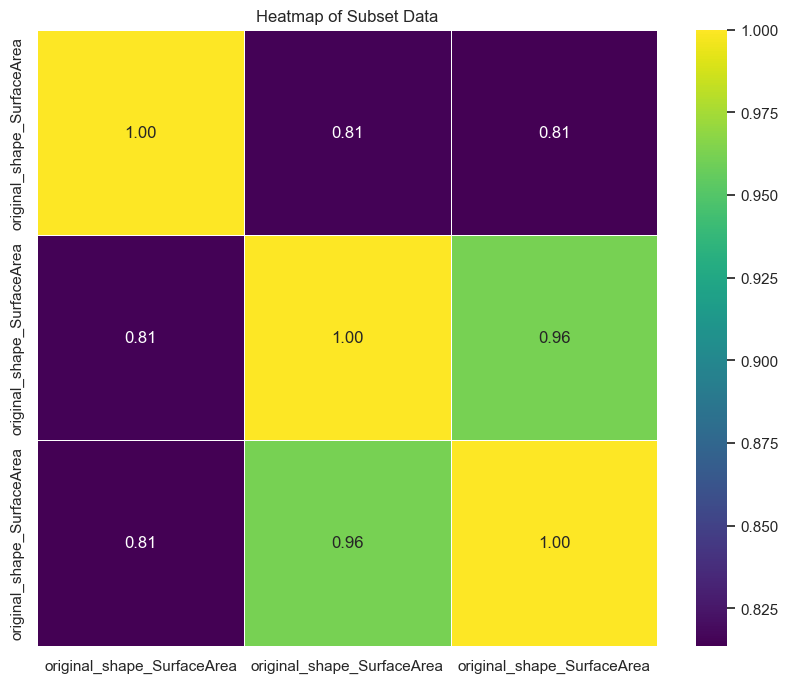

In [45]:
# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corre, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Heatmap of Subset Data')
plt.show()

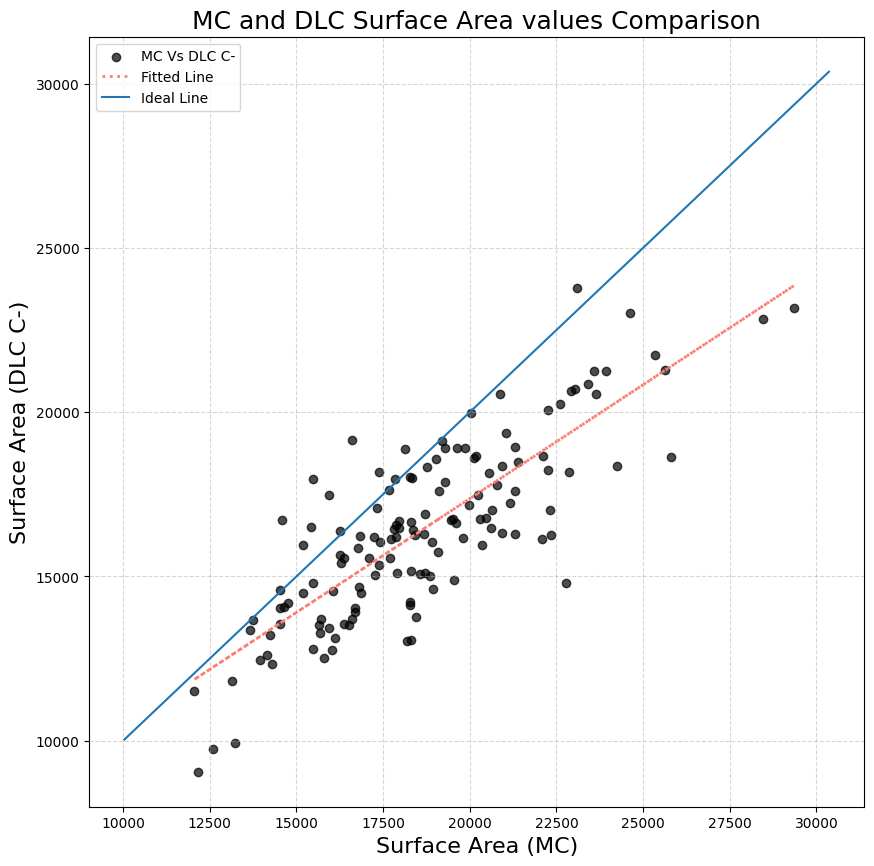

In [8]:
x_element_list = [mc.original_shape_SurfaceArea]
y_element_list = [dlc_without.original_shape_SurfaceArea]

line_info= [[np.min(mc.original_shape_SurfaceArea) -2000, np.max(mc.original_shape_SurfaceArea) + 1000], 
            [np.min(mc.original_shape_SurfaceArea)- 2000, np.max(mc.original_shape_SurfaceArea) + 1000], 'Ideal Line']

color_list = ['black']
label_list = ['MC Vs DLC C-']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Surface Area (MC)', 'y': 'Surface Area (DLC C-)', 'title':'MC and DLC Surface Area values Comparison'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict, True, line_info, True)

#### Normalized df

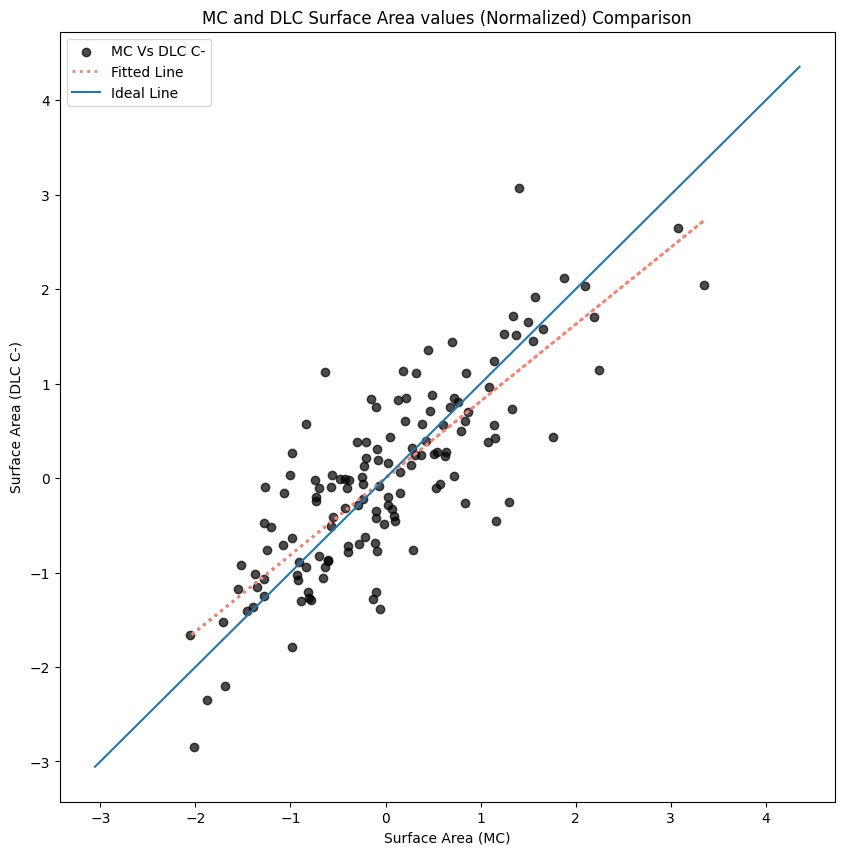

In [46]:
x_element_list = [norm_mc_surf]
y_element_list = [norm_with_surf]

line_info= [[np.min(norm_mc_surf) -1, np.max(norm_mc_surf) + 1], 
            [np.min(norm_mc_surf)- 1, np.max(norm_mc_surf) + 1], 'Ideal Line']

color_list = ['black']
label_list = ['MC Vs DLC C-']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Surface Area (MC)', 'y': 'Surface Area (DLC C-)', 'title':'MC and DLC Surface Area values (Normalized) Comparison'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict, True, line_info, True)

### Surface Dice

137


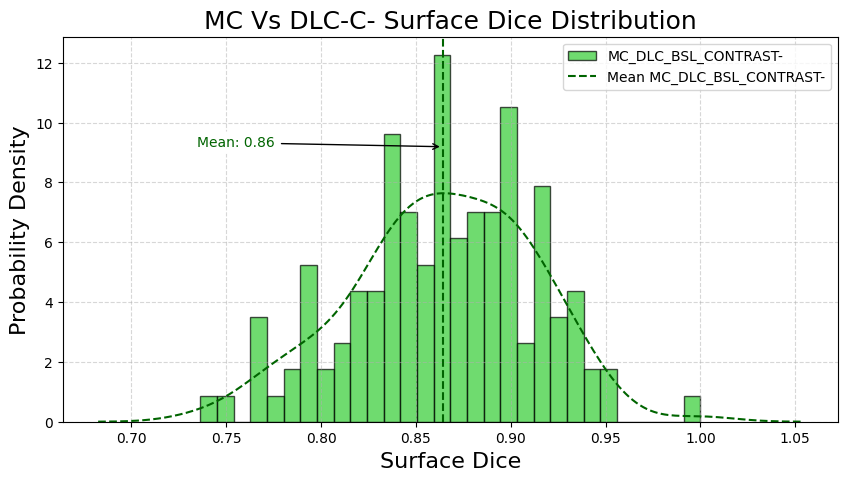

In [14]:
dice_mc_dlc_bsl_without = pd.read_excel('Dice_MC_DLC_BSL_without.xlsx').rename(columns={'Unnamed: 0': 'ID'})
#dice_mc_dlc_bsl_without = dice_mc_dlc_bsl_without[dice_mc_dlc_bsl_without.OAR=='total']
print(dice_mc_dlc_bsl_without.ID.nunique())

element_list = dice_mc_dlc_bsl_without[dice_mc_dlc_bsl_without.Surface_dice> 0.5 ]
element_list = [element_list.Surface_dice]
color_list = ['limegreen']
label_list = ['MC_DLC_BSL_CONTRAST-']
alpha_list = [0.7]
figure_dict = {'x': 'Surface Dice', 'y': 'Probability Density', 'title':'MC Vs DLC-C- Surface Dice Distribution'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

### Violin Plot

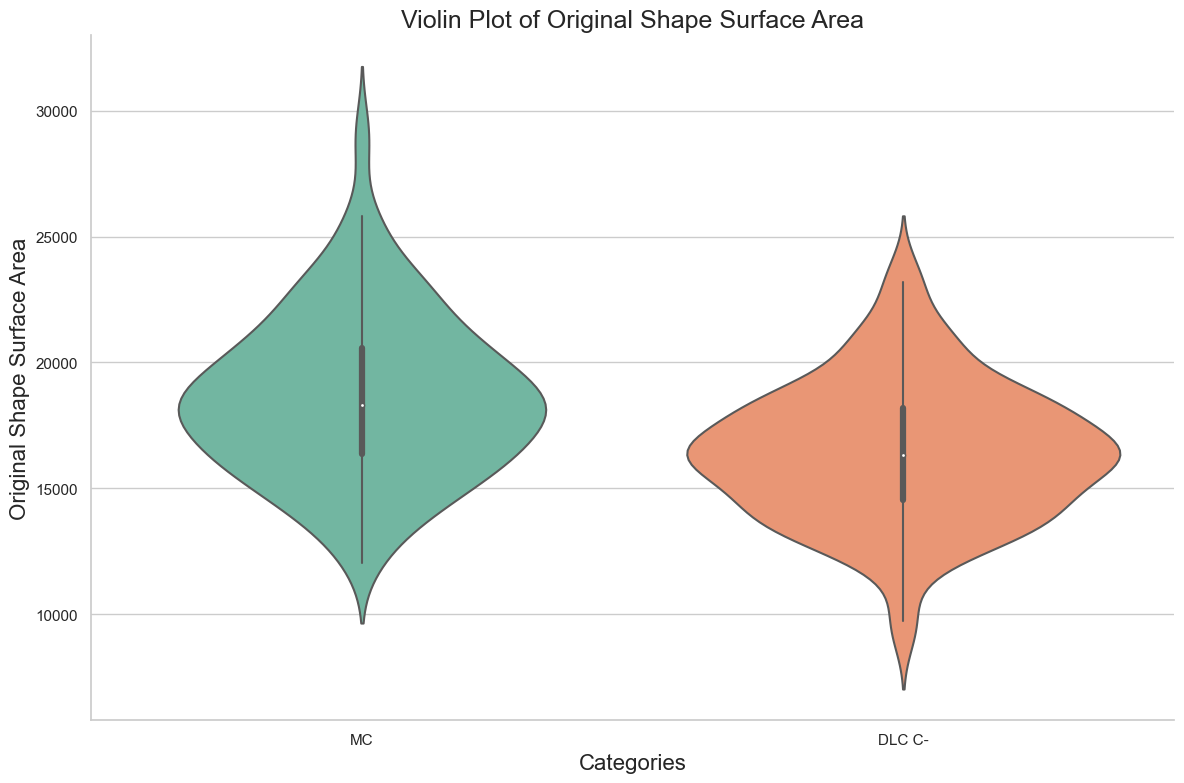

In [24]:
# Extract the relevant columns from each DataFrame
mc_data = mc[['original_shape_SurfaceArea']].reset_index(drop=True)
without_data = dlc_without[['original_shape_SurfaceArea']].reset_index(drop=True)
#with_data = dlc_with[['original_shape_SurfaceArea']].reset_index(drop=True)

# Create the DataFrame
category_df = pd.DataFrame({'MC': mc_data['original_shape_SurfaceArea'],
                            'DLC C-': without_data['original_shape_SurfaceArea']})

making_violin_plot(category_df)

## DLC Contrast+ Vs DLC Contrast-

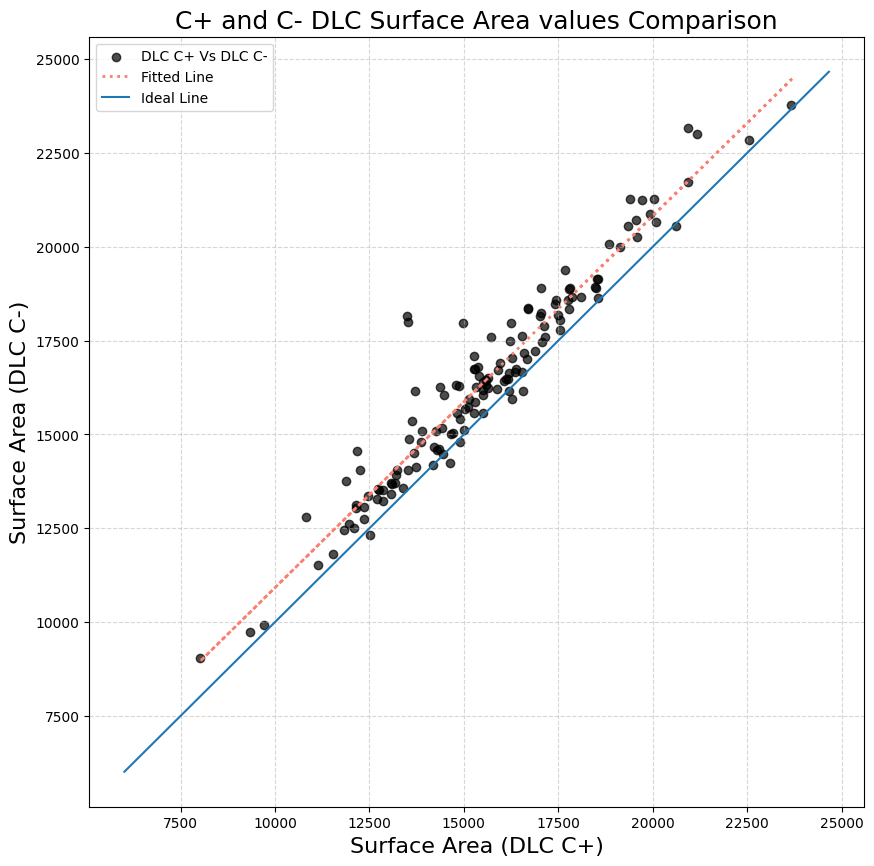

In [9]:
x_element_list = [dlc_with.original_shape_SurfaceArea]
y_element_list = [dlc_without.original_shape_SurfaceArea]

line_info= [[np.min(dlc_with.original_shape_SurfaceArea) -2000, np.max(dlc_with.original_shape_SurfaceArea) + 1000], 
            [np.min(dlc_with.original_shape_SurfaceArea)- 2000, np.max(dlc_with.original_shape_SurfaceArea) + 1000], 'Ideal Line']

color_list = ['black']
label_list = ['DLC C+ Vs DLC C-']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Surface Area (DLC C+)', 'y': 'Surface Area (DLC C-)', 'title':'C+ and C- DLC Surface Area values Comparison'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict, True, line_info, True)

### Normalization

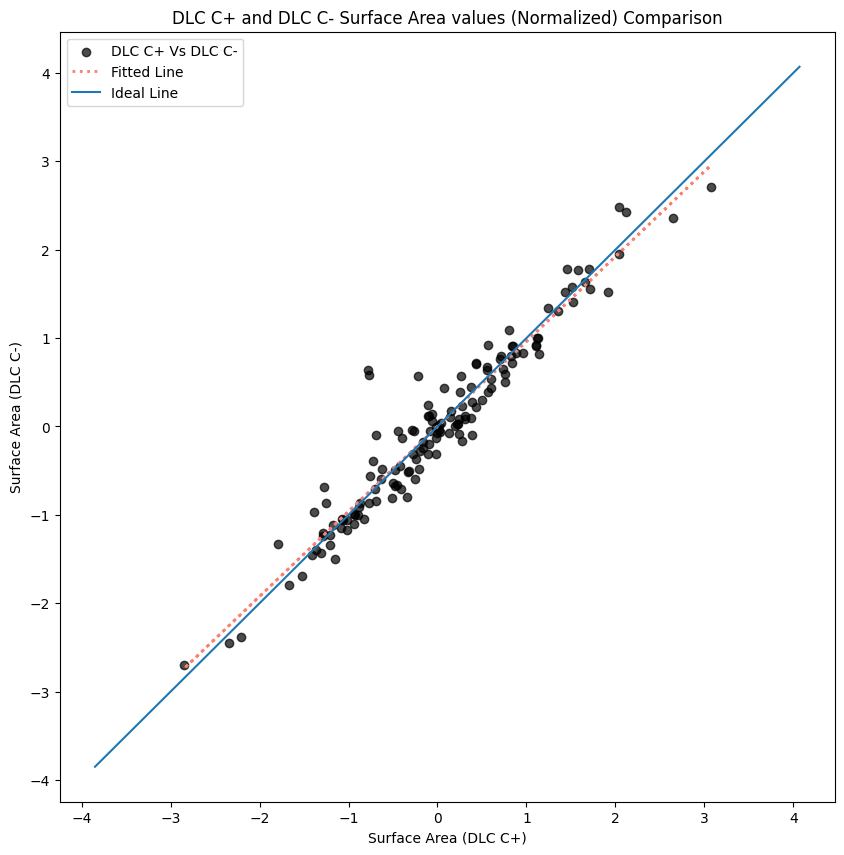

In [48]:
x_element_list = [norm_with_surf]
y_element_list = [norm_without_surf]

line_info= [[np.min(norm_with_surf) -1, np.max(norm_with_surf) + 1], 
            [np.min(norm_with_surf)- 1, np.max(norm_with_surf) + 1], 'Ideal Line']

color_list = ['black']
label_list = ['DLC C+ Vs DLC C-']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Surface Area (DLC C+)', 'y': 'Surface Area (DLC C-)', 'title':'DLC C+ and DLC C- Surface Area values (Normalized) Comparison'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict, True, line_info, True)

### Violin Plot

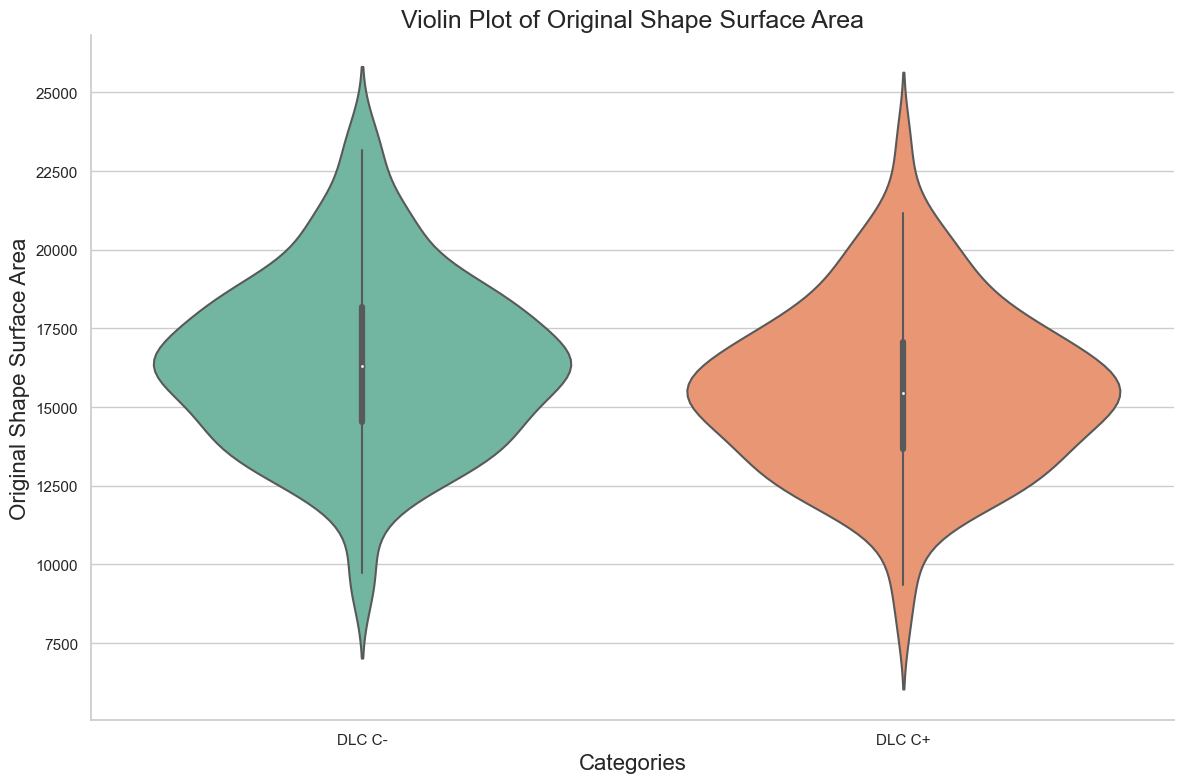

In [32]:
# Extract the relevant columns from each DataFrame
mc_data = mc[['original_shape_SurfaceArea']].reset_index(drop=True)
without_data = dlc_without[['original_shape_SurfaceArea']].reset_index(drop=True)
with_data = dlc_with[['original_shape_SurfaceArea']].reset_index(drop=True)

# Create the DataFrame
category_df = pd.DataFrame({
                            'DLC C-': without_data['original_shape_SurfaceArea'],
                            'DLC C+': with_data['original_shape_SurfaceArea']})

making_violin_plot(category_df)

### Surface Dice

137


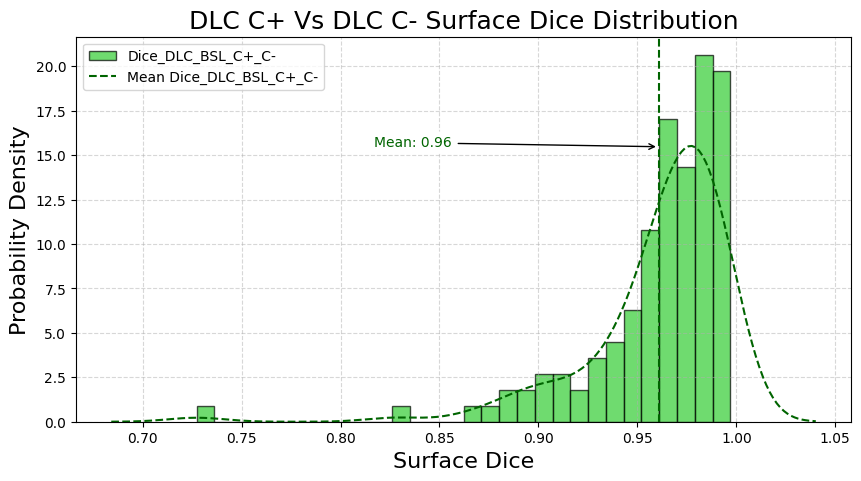

In [15]:
dice_dlc_bsl_with_without = pd.read_excel('Dice_DLC_BSL_with_without.xlsx').rename(columns={'Unnamed: 0': 'ID'})
dice_dlc_bsl_with_without = dice_dlc_bsl_with_without[dice_dlc_bsl_with_without.OAR=='total']
print(dice_dlc_bsl_with_without.ID.nunique())

element_list = dice_dlc_bsl_with_without[dice_dlc_bsl_with_without.Surface_dice> 0.5 ]
element_list = [element_list.Surface_dice]

color_list = ['limegreen']
label_list = ['Dice_DLC_BSL_C+_C-']
alpha_list = [0.7]
figure_dict = {'x': 'Surface Dice', 'y': 'Probability Density', 'title':'DLC C+ Vs DLC C- Surface Dice Distribution'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

## MC Vs DLC wk3

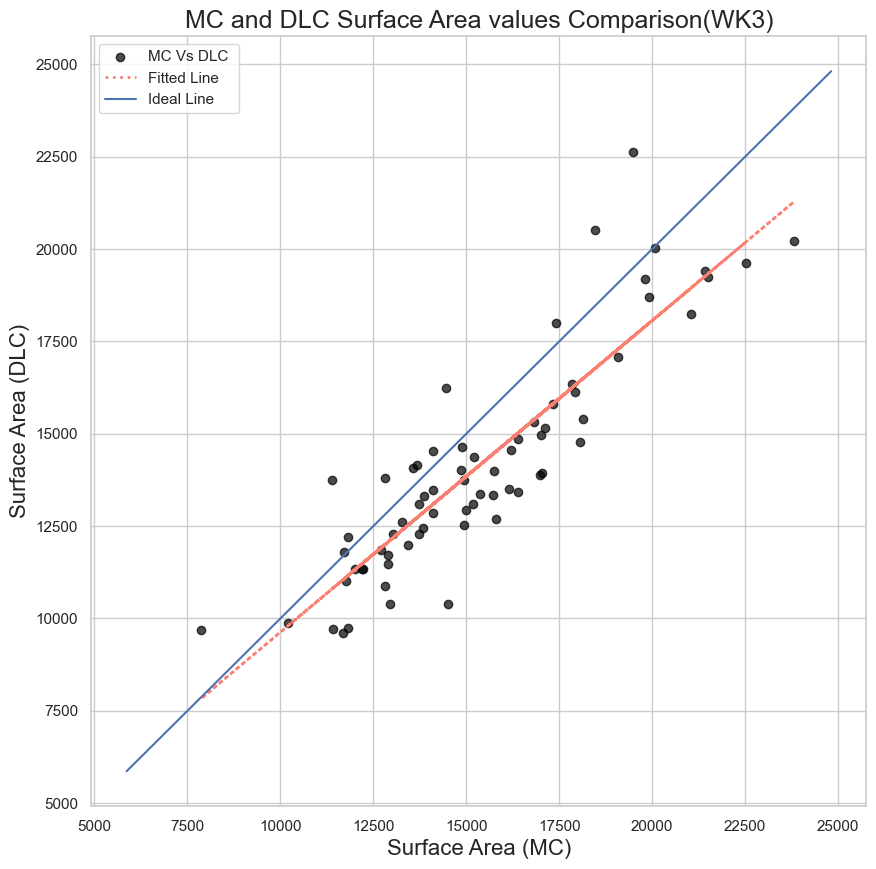

In [33]:
x_element_list = [mc_wk3.original_shape_SurfaceArea]
y_element_list = [dlc_wk3.original_shape_SurfaceArea]

line_info= [[np.min(mc_wk3.original_shape_SurfaceArea) -2000, np.max(mc_wk3.original_shape_SurfaceArea) + 1000], 
            [np.min(mc_wk3.original_shape_SurfaceArea)- 2000, np.max(mc_wk3.original_shape_SurfaceArea) + 1000], 'Ideal Line']

color_list = ['black']
label_list = ['MC Vs DLC ']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Surface Area (MC)', 'y': 'Surface Area (DLC)', 'title':'MC and DLC Surface Area values Comparison(WK3)'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict, True, line_info, True)

### Normalization

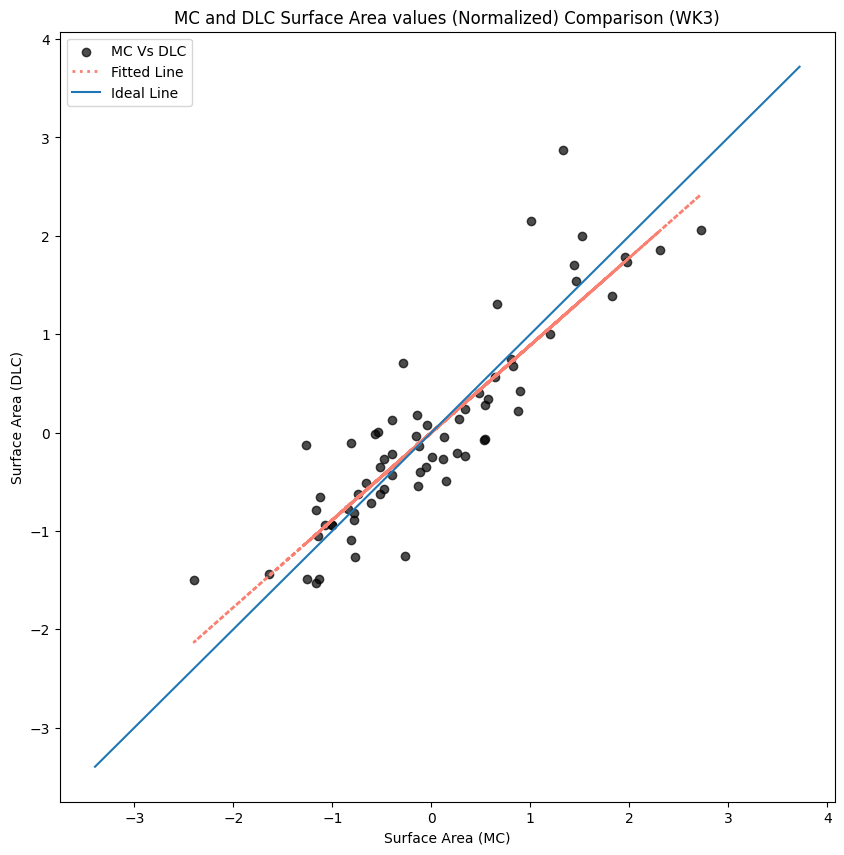

In [62]:
x_element_list = [norm_mc_wk3_surf]
y_element_list = [norm_dlc_wk3_surf]

line_info= [[np.min(norm_mc_wk3_surf) -1, np.max(norm_mc_wk3_surf) + 1], 
            [np.min(norm_mc_wk3_surf)- 1, np.max(norm_mc_wk3_surf) + 1], 'Ideal Line']

color_list = ['black']
label_list = ['MC Vs DLC']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Surface Area (MC)', 'y': 'Surface Area (DLC)', 'title':'MC and DLC Surface Area values (Normalized) Comparison (WK3)'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict, True, line_info, True)

### Violin Plot


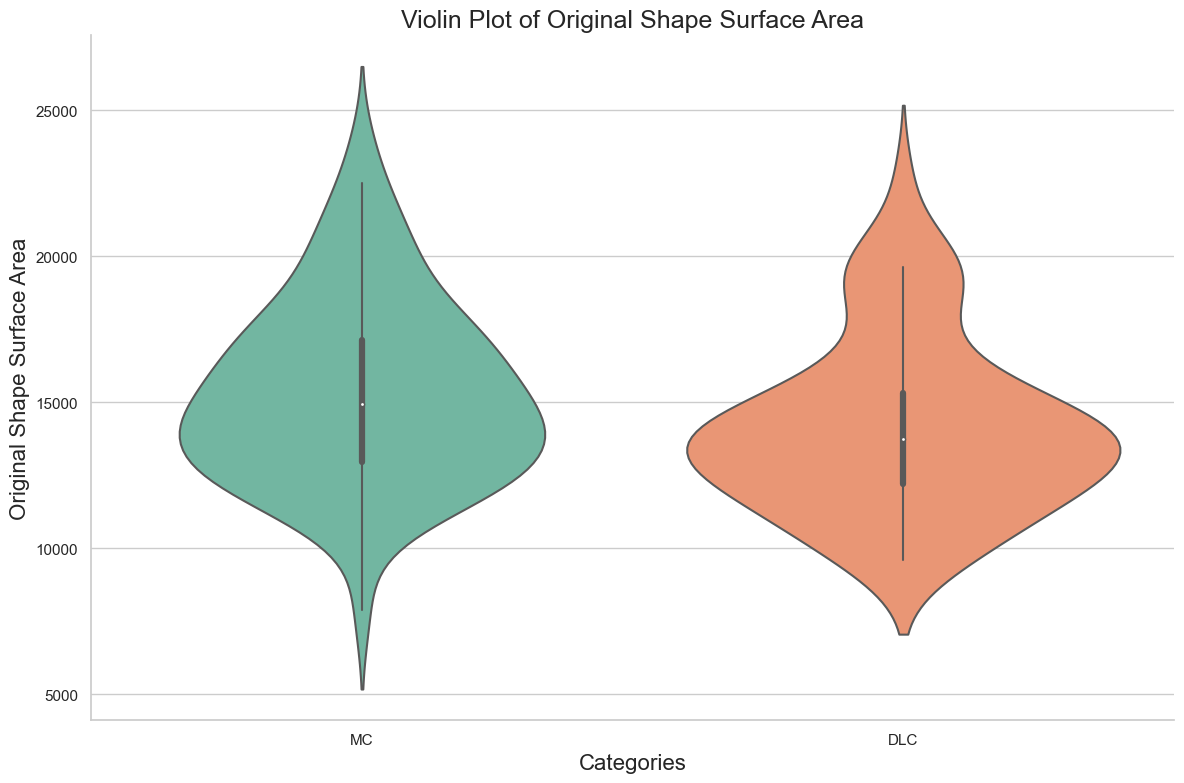

In [34]:
# Extract the relevant columns from each DataFrame
mc_data = mc_wk3[['original_shape_SurfaceArea']].reset_index(drop=True)
dlc_data = dlc_wk3[['original_shape_SurfaceArea']].reset_index(drop=True)

# Create the DataFrame
category_df = pd.DataFrame({
                            'MC': mc_data['original_shape_SurfaceArea'],
                            'DLC': dlc_data['original_shape_SurfaceArea']})

making_violin_plot(category_df)

### Surface Dice

68


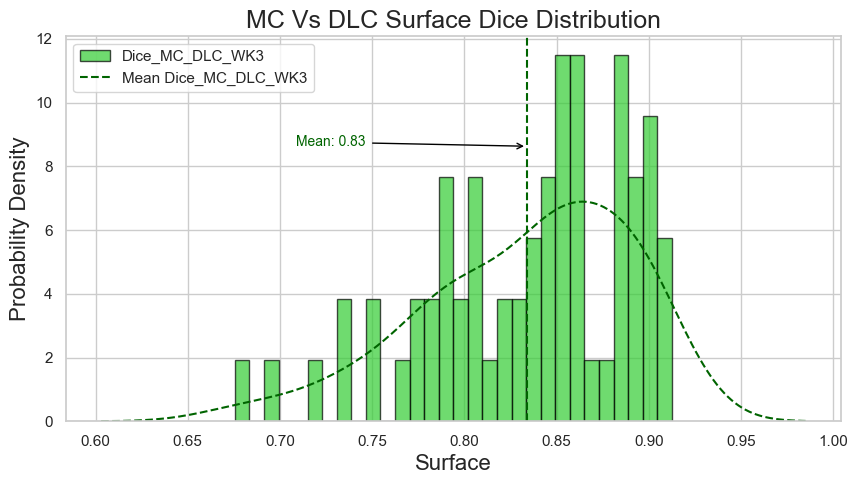

In [76]:
dice_dlc_wk3 = pd.read_excel('Dice_MC_DLC_BSL_wk3.xlsx').rename(columns={'Unnamed: 0': 'ID'})
dice_dlc_wk3 = dice_dlc_wk3[dice_dlc_wk3.OAR=='total']
print(dice_dlc_wk3.ID.nunique())

element_list = dice_dlc_wk3[dice_dlc_wk3.Surface_dice> 0.5 ]
element_list = [element_list.Surface_dice]

color_list = ['limegreen']
label_list = ['Dice_MC_DLC_WK3']
alpha_list = [0.7]
figure_dict = {'x': 'Surface', 'y': 'Probability Density', 'title':'MC Vs DLC Surface Dice Distribution'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

## Delta-radiomics MC Vs DLC

In [12]:
# Links
mc_wk3_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Rf_wk3_mc_total.xlsx'
dlc_wk3_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Rf_wk3_dlc_total.xlsx'
mc_bsl_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Rf_bsl_mc_total.xlsx'
dlc_bsl_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Rf_bsl_dlc_total.xlsx'


# Read the dataframe.
mc_wk3_df = pd.read_excel(mc_wk3_path).drop(columns=['Unnamed: 0'])
dlc_wk3_df = pd.read_excel(dlc_wk3_path).drop(columns=['Unnamed: 0'])
mc_bsl_df = pd.read_excel(mc_bsl_path).drop(columns=['Unnamed: 0'])

# Convert the dlc baseline datafram in a comparieble way.
dlc_bsl_df = pd.read_excel(dlc_bsl_path)
dlc_bsl_df['Unnamed: 0'] = dlc_bsl_df['Unnamed: 0'].fillna(method='ffill')
dlc_bsl_df.rename(columns= {'Unnamed: 0':'ID', 'Unnamed: 1': 'OAR'}, inplace=True)
dlc_bsl_df.ID = dlc_bsl_df.ID.astype(int)
dlc_bsl_df.head()


# Slice the part of the dataset that Sanne used for her model.
dlc_wk3_df = dlc_wk3_df[dlc_wk3_df.ID.isin(list(mc_wk3_df.ID.unique()))]
mc_wk3_df = mc_wk3_df[mc_wk3_df.ID.isin(list(dlc_wk3_df.ID.unique()))]
mc_bsl_df = mc_bsl_df[mc_bsl_df.ID.isin(list(dlc_wk3_df.ID.unique()))]
dlc_bsl_df = dlc_bsl_df[dlc_bsl_df.ID.isin(list(dlc_wk3_df.ID.unique()))]

print('Number of patients per each dataset')
print(dlc_wk3_df.ID.nunique(), mc_wk3_df.ID.nunique(), mc_bsl_df.ID.nunique(), dlc_bsl_df.ID.nunique())

# Choose the total part
mc_wk3_total_df = mc_wk3_df[mc_wk3_df.OAR == 'total']
dlc_wk3_total_df = dlc_wk3_df[dlc_wk3_df.OAR == 'total']
mc_bsl_total_df = mc_bsl_df[mc_bsl_df.OAR == 'total']
dlc_bsl_total_df = dlc_bsl_df[dlc_bsl_df.OAR == 'total']

# Sort the datasets based on IDs
dlc_wk3_total_df = dlc_wk3_total_df.set_index('ID').sort_index()
mc_wk3_total_df = mc_wk3_total_df.set_index('ID').sort_index()
mc_bsl_total_df = mc_bsl_total_df.set_index('ID').sort_index()
dlc_bsl_total_df = dlc_bsl_total_df.set_index('ID').sort_index()

# Slice the surface area column
mc_wk3_surf = mc_wk3_total_df[['original_shape_SurfaceArea', 'original_shape_VoxelVolume']]
dlc_wk3_surf = dlc_wk3_total_df[['original_shape_SurfaceArea', 'original_shape_VoxelVolume']]
mc_bsl_surf = mc_bsl_total_df[['original_shape_SurfaceArea', 'original_shape_VoxelVolume']]
dlc_bsl_surf = dlc_bsl_total_df[['original_shape_SurfaceArea', 'original_shape_VoxelVolume']]

Number of patients per each dataset
69 69 69 69


In [13]:
# Without Normalization
mc_delta_surf = mc_bsl_surf.original_shape_SurfaceArea - mc_wk3_surf.original_shape_SurfaceArea
dlc_delta_surf = dlc_bsl_surf.original_shape_SurfaceArea - dlc_wk3_surf.original_shape_SurfaceArea

mc_delta_vol = mc_bsl_surf.original_shape_VoxelVolume - mc_wk3_surf.original_shape_VoxelVolume
dlc_delta_vol = dlc_bsl_surf.original_shape_VoxelVolume - dlc_wk3_surf.original_shape_VoxelVolume

In [14]:
# Normalized
normalized_mc_delta_surf = normalizing_feature(mc_bsl_surf.original_shape_SurfaceArea) - normalizing_feature(mc_wk3_surf.original_shape_SurfaceArea)
normalized_dlc_delta_surf = normalizing_feature(dlc_bsl_surf.original_shape_SurfaceArea) - normalizing_feature(dlc_wk3_surf.original_shape_SurfaceArea)

normalized_mc_delta_vol = normalizing_feature(mc_bsl_surf.original_shape_VoxelVolume) - normalizing_feature(mc_wk3_surf.original_shape_VoxelVolume)
normalized_dlc_delta_vol = normalizing_feature(dlc_bsl_surf.original_shape_VoxelVolume) - normalizing_feature(dlc_wk3_surf.original_shape_VoxelVolume)

In [15]:
mc_delta_surf_norm = normalizing_feature(mc_delta_surf)
dlc_delta_surf_norm = normalizing_feature(dlc_delta_surf)
mc_delta_vol_norm = normalizing_feature(mc_delta_vol)
dlc_delta_vol_norm = normalizing_feature(dlc_delta_vol)

### Surface Area

#### Subtraction then normalization

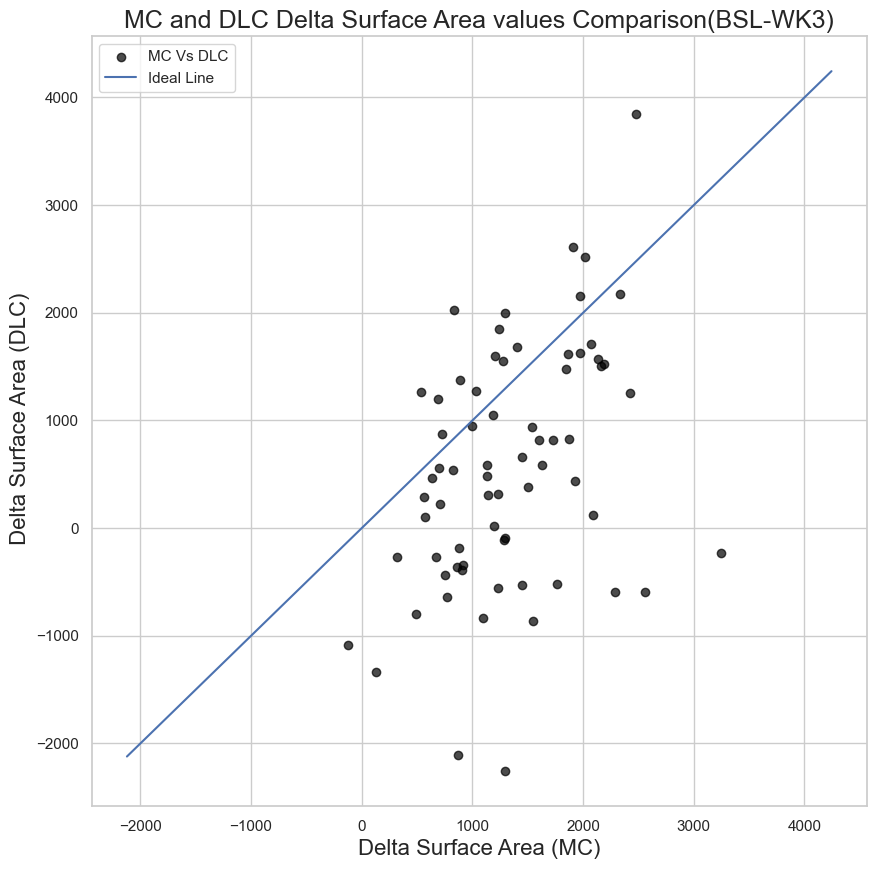

In [19]:
x_element_list = [mc_delta_surf]
y_element_list = [dlc_delta_surf]

line_info= [[np.min(mc_delta_surf) -2000, np.max(mc_delta_surf) + 1000], 
            [np.min(mc_delta_surf)- 2000, np.max(mc_delta_surf) + 1000], 'Ideal Line']

color_list = ['black']
label_list = ['MC Vs DLC']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Delta Surface Area (MC)', 'y': ' Delta Surface Area (DLC)', 'title':'MC and DLC Delta Surface Area values Comparison(BSL-WK3)'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict, True, line_info, False)

#### Violin Plot

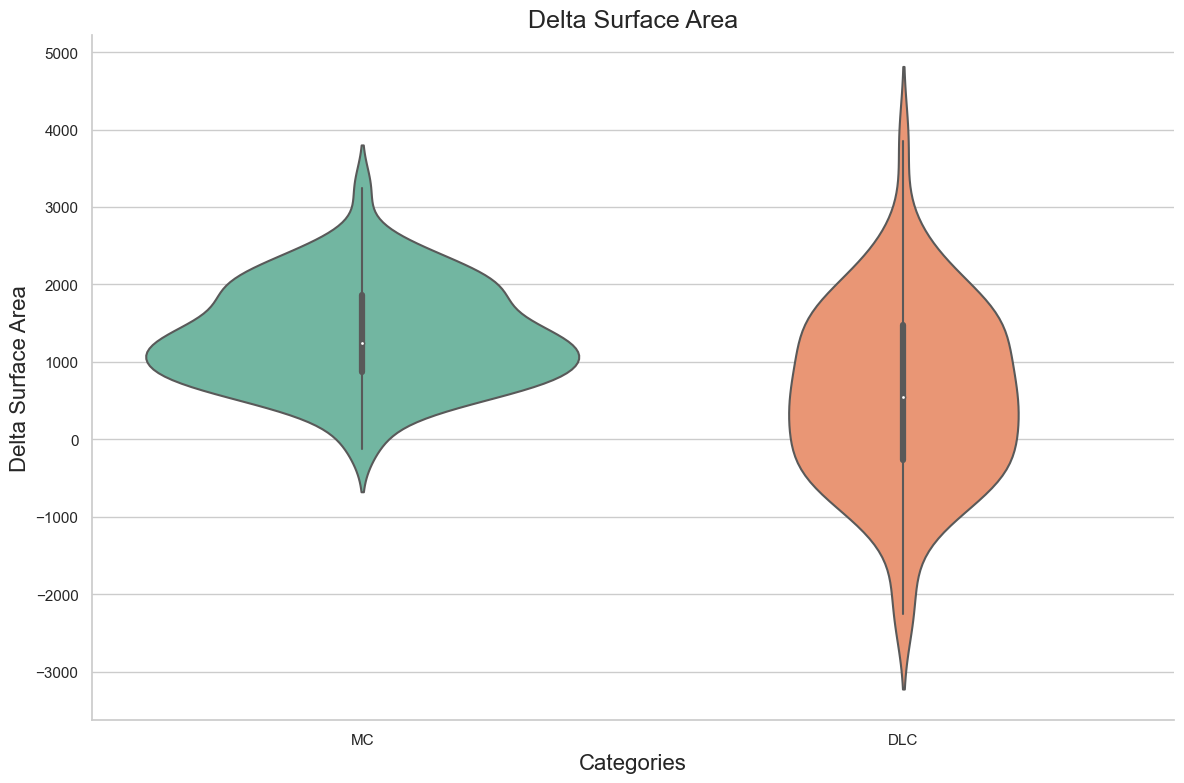

In [21]:
# Extract the relevant columns from each DataFrame
mc_data = mc_delta_surf
dlc_data = dlc_delta_surf

# Create the DataFrame
category_df = pd.DataFrame({
                            'MC': mc_data,
                            'DLC': dlc_data})

making_violin_plot(category_df)

### Normalization

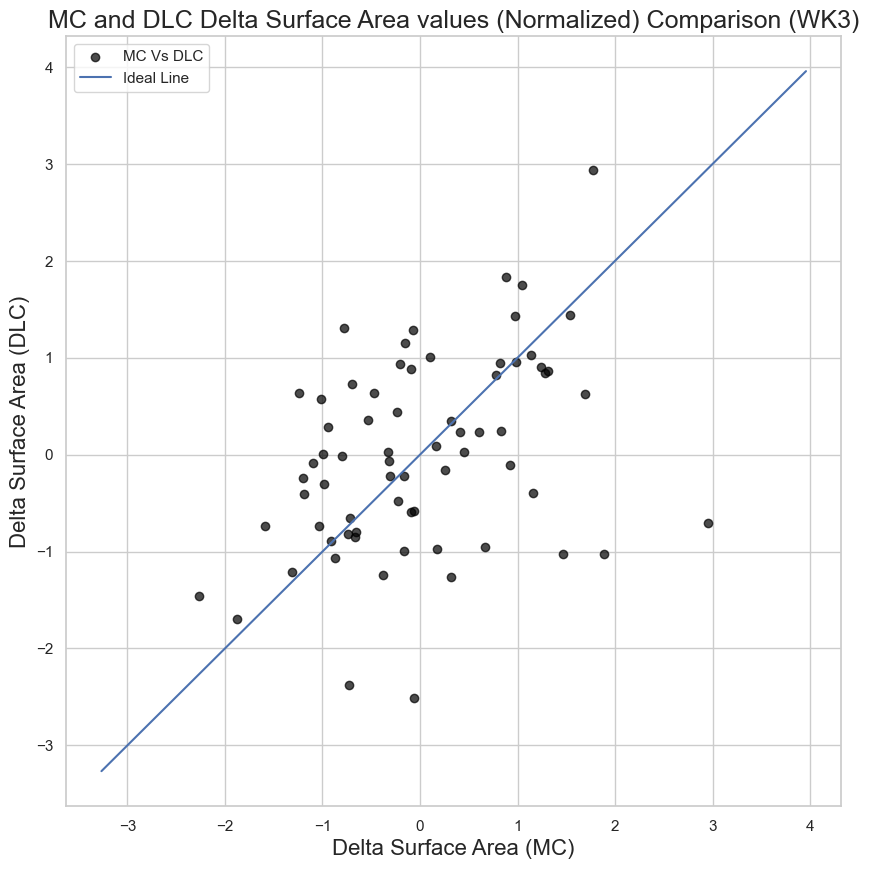

In [26]:
x_element_list = [mc_delta_surf_norm]
y_element_list = [dlc_delta_surf_norm]

line_info= [[np.min(mc_delta_surf_norm) -1, np.max(mc_delta_surf_norm) + 1], 
            [np.min(mc_delta_surf_norm)- 1, np.max(mc_delta_surf_norm) + 1], 'Ideal Line']

color_list = ['black']
label_list = ['MC Vs DLC']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Delta Surface Area (MC)', 'y': 'Delta Surface Area (DLC)', 'title':'MC and DLC Delta Surface Area values (Normalized) Comparison (WK3)'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict, True, line_info, False)

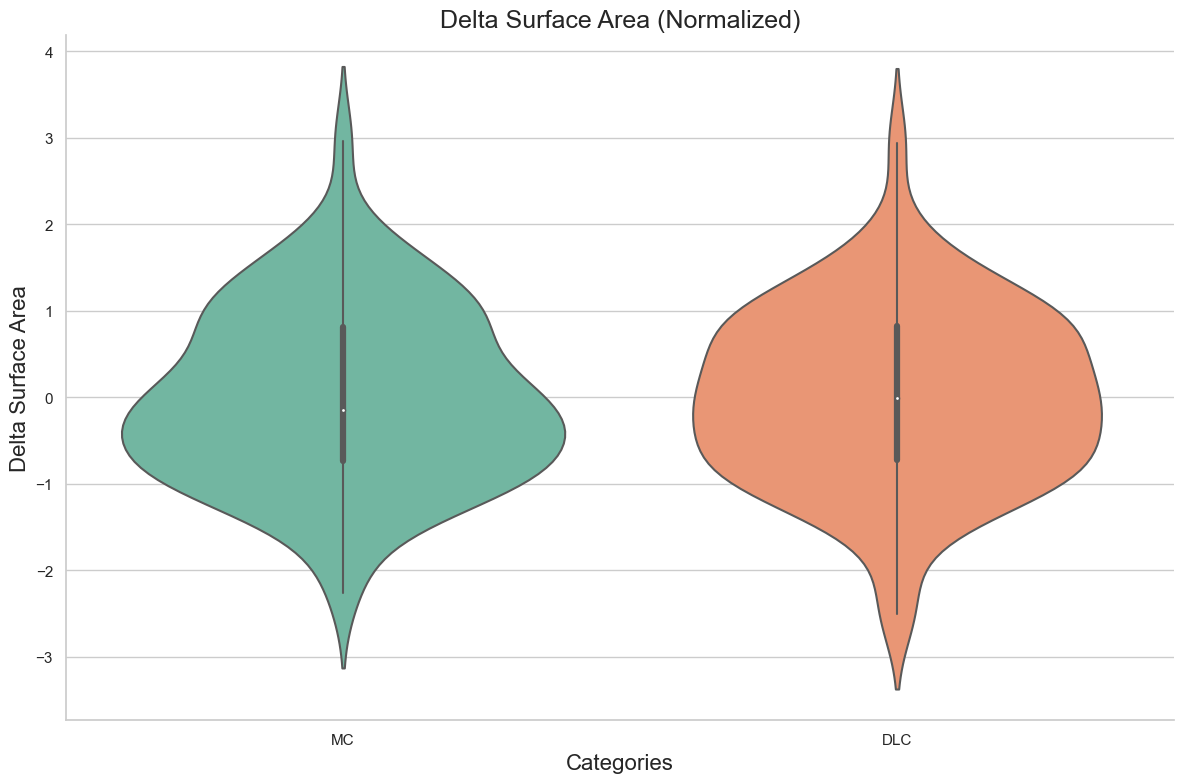

In [25]:
# Extract the relevant columns from each DataFrame
mc_data = mc_delta_surf_norm
dlc_data = dlc_delta_surf_norm

# Create the DataFrame
category_df = pd.DataFrame({
                            'MC': mc_data,
                            'DLC': dlc_data})

making_violin_plot(category_df)

#### Nomalization then subtraction

In [76]:
normalized_mc_delta_surf = normalizing_feature(normalized_mc_delta_surf)
normalized_dlc_delta_surf = normalizing_feature(normalized_dlc_delta_surf)

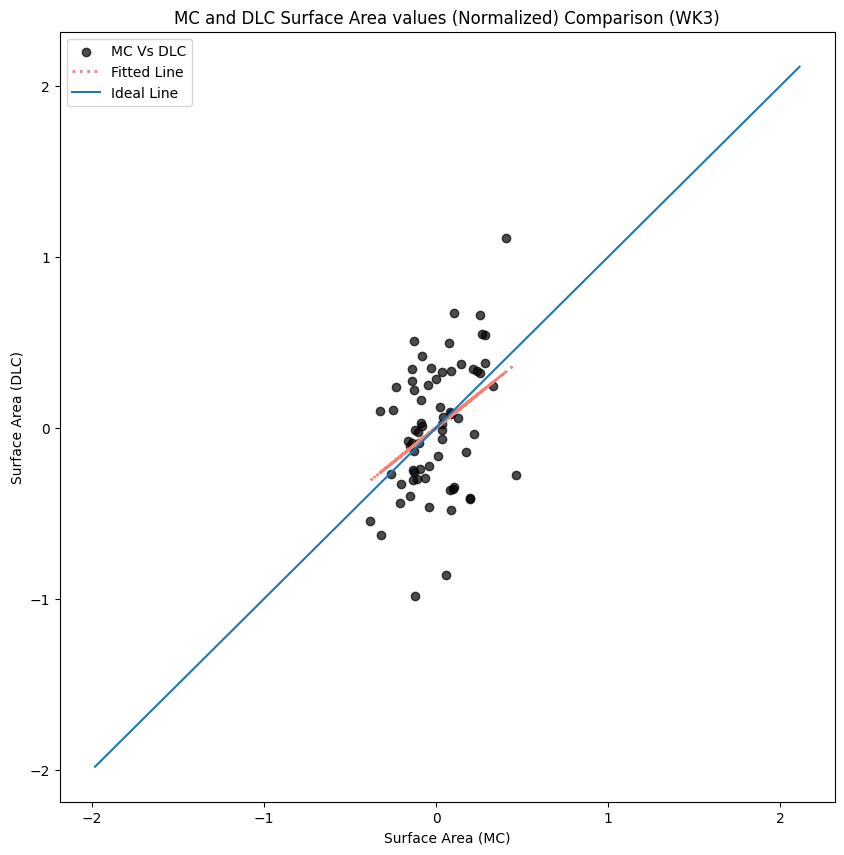

In [80]:
x_element_list = [normalized_mc_delta_surf]
y_element_list = [normalized_dlc_delta_surf]

line_info= [[np.min(normalized_dlc_delta_surf) -1, np.max(normalized_dlc_delta_surf) + 1], 
            [np.min(normalized_dlc_delta_surf)- 1, np.max(normalized_dlc_delta_surf) + 1], 'Ideal Line']

color_list = ['black']
label_list = ['MC Vs DLC']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Surface Area (MC)', 'y': 'Surface Area (DLC)', 'title':'MC and DLC Surface Area values (Normalized) Comparison (WK3)'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict, True, line_info, True)